Сталь – один из важнейших строительных материалов современности. Стальные здания устойчивы к естественному и искусственному износу, что сделало этот материал повсеместно распространенным во всем мире. Чтобы сделать производство стали более эффективным, этот конкурс поможет выявить дефекты.


ссылка на каггл с этим соревнованием - https://www.kaggle.com/c/severstal-steel-defect-detection

### Постановка задачи :

Этот конкурс представляет собой двойной конкурс: классифицируйте тип дефекта стали, а также сегментируйте части изображения, содержащие дефект.



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import keras
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from sklearn.preprocessing import OneHotEncoder,LabelEncoder
from keras.utils import to_categorical
from keras.models import Sequential
import tensorflow as tf
from keras.layers import Dense,Conv2D,Flatten,MaxPooling2D,Dropout

In [2]:
data = pd.read_csv('/kaggle/input/severstal-steel-defect-detection/train.csv')

In [3]:
data

,ImageId,ClassId,EncodedPixels
0,0002cc93b.jpg,1,29102 12 29346 24 29602 24 29858 24 30114 24 3...
1,0007a71bf.jpg,3,18661 28 18863 82 19091 110 19347 110 19603 11...
2,000a4bcdd.jpg,1,37607 3 37858 8 38108 14 38359 20 38610 25 388...
3,000f6bf48.jpg,4,131973 1 132228 4 132483 6 132738 8 132993 11 ...
4,0014fce06.jpg,3,229501 11 229741 33 229981 55 230221 77 230468...
...,...,...,...
7090,ffcf72ecf.jpg,3,121911 34 122167 101 122422 169 122678 203 122...
7091,fff02e9c5.jpg,3,207523 3 207777 9 208030 15 208283 22 208537 2...
7092,fffe98443.jpg,3,105929 5 106177 14 106424 24 106672 33 106923 ...
7093,ffff4eaa8.jpg,3,16899 7 17155 20 17411 34 17667 47 17923 60 18...


In [4]:
data.shape

(7095, 3)

У нас 7095 и три фичи

# Разведочный анализ данных

ClassId
3    5150
1     897
4     801
2     247
Name: count, dtype: int64

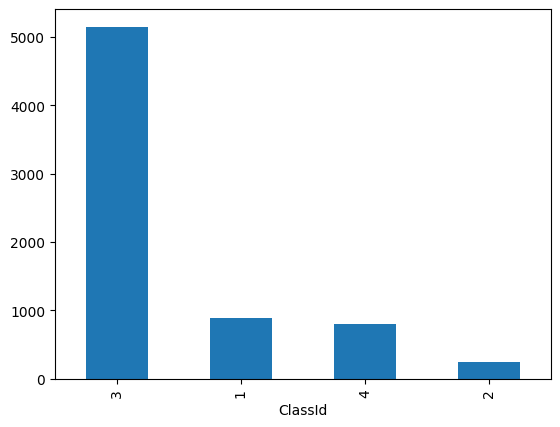

In [5]:
data["ClassId"].value_counts().plot(kind = 'bar')
data["ClassId"].value_counts()

больше всего меток третьего класса

Перекос данных, поэтому выполним аугментацию.

In [6]:
import cv2

In [7]:
l1=[]
l2=[]
for img,ClassId,EncodedPixels in tqdm(data.values):
    image=cv2.imread("/kaggle/input/severstal-steel-defect-detection/train_images/{}".format(img),cv2.IMREAD_COLOR)
    image=cv2.resize(image,(120,120))
    l1.append(image)
    l2.append(ClassId)

100%|██████████| 7095/7095 [02:23<00:00, 49.46it/s]


Проверка изображений случайной стали, чтобы проверить, дефектна ли она или нет.

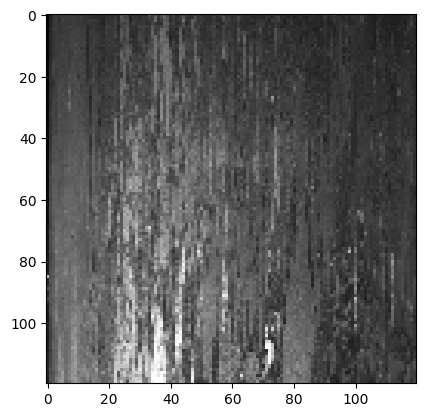

In [8]:
i = 15
plt.imshow(l1[i])

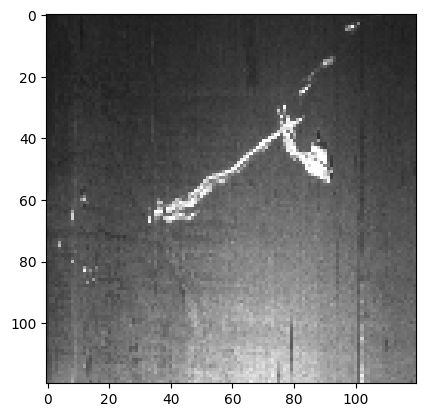

In [9]:
i = 16
plt.imshow(l1[i])

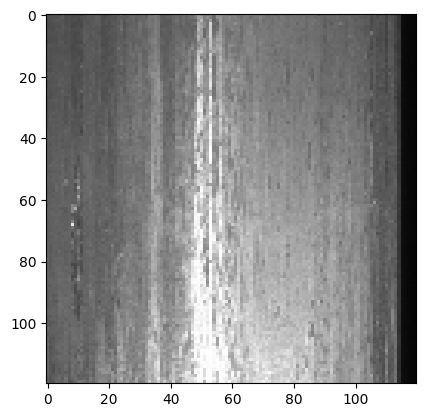

In [10]:
i = 90
plt.imshow(l1[i])

Выполним one-hot кодировку

In [11]:
encoder = LabelEncoder()

X= np.array(l1)
X = X/255

y = encoder.fit_transform(l2)
y = np.array(y)


In [12]:
X.shape

(7095, 120, 120, 3)

In [13]:
y.shape

(7095,)

# Борьба с дибалансом

для борьбы с дисбалансом выполним случайное сэмплирование

In [14]:
from imblearn.over_sampling import RandomOverSampler
reshaped_X = X.reshape(X.shape[0],-1)
oversample = RandomOverSampler(sampling_strategy='not majority')
X, y  = oversample.fit_resample(reshaped_X , y)
X = X.reshape(-1,120,120,3)

In [15]:
X.shape

(20600, 120, 120, 3)

In [16]:

y = to_categorical(y)

In [17]:
y

array([[1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       ...,
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.]], dtype=float32)

разделим на тренировку и валидацию

In [18]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,stratify=y,shuffle=True)

In [19]:
print("x_train размер:",X_train.shape)
print("x_test размер:",X_test.shape)
print("y_train размер:",y_train.shape)
print("y_test размер:",y_test.shape)

x_train размер: (16480, 120, 120, 3)
x_test размер: (4120, 120, 120, 3)
y_train размер: (16480, 4)
y_test размер: (4120, 4)


# Построение нейронной сети  в 3 слоя и график обучения

In [20]:
model=Sequential()
model.add(Conv2D(32,(3,3),input_shape=(120,120,3),activation="relu"))
model.add(Flatten())
model.add(Dense(4,activation="softmax"))

In [21]:
model.compile(loss=keras.losses.categorical_crossentropy,
             optimizer=keras.optimizers.Adam(),
             metrics=["accuracy"])

In [22]:
history = model.fit(X_train,y_train,epochs=10,validation_data=(X_test,y_test),batch_size=128,
                    verbose=1)

Epoch 1/10
129/129 [==============================] - 81s 619ms/step - loss: 1.5038 - accuracy: 0.6184 - val_loss: 0.6306 - val_accuracy: 0.7515
Epoch 2/10
129/129 [==============================] - 78s 605ms/step - loss: 0.4867 - accuracy: 0.8254 - val_loss: 0.4280 - val_accuracy: 0.8587
Epoch 3/10
129/129 [==============================] - 78s 607ms/step - loss: 0.3264 - accuracy: 0.8989 - val_loss: 0.3734 - val_accuracy: 0.8714
Epoch 4/10
129/129 [==============================] - 78s 603ms/step - loss: 0.2546 - accuracy: 0.9255 - val_loss: 0.3579 - val_accuracy: 0.8835
Epoch 5/10
129/129 [==============================] - 78s 605ms/step - loss: 0.2188 - accuracy: 0.9388 - val_loss: 0.3155 - val_accuracy: 0.9068
Epoch 6/10
129/129 [==============================] - 78s 604ms/step - loss: 0.1987 - accuracy: 0.9462 - val_loss: 0.2865 - val_accuracy: 0.9138
Epoch 7/10
129/129 [==============================] - 78s 606ms/step - loss: 0.1770 - accuracy: 0.9538 - val_loss: 0.2813 - val_ac

<Axes: title={'center': 'Loss curve'}>

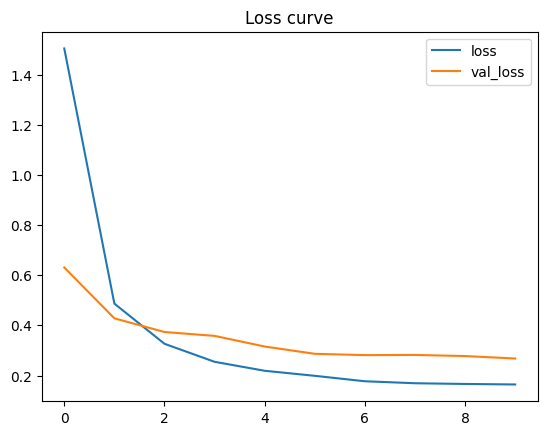

In [23]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot(title = 'Loss curve')

<Axes: title={'center': 'Accuracy curve'}>

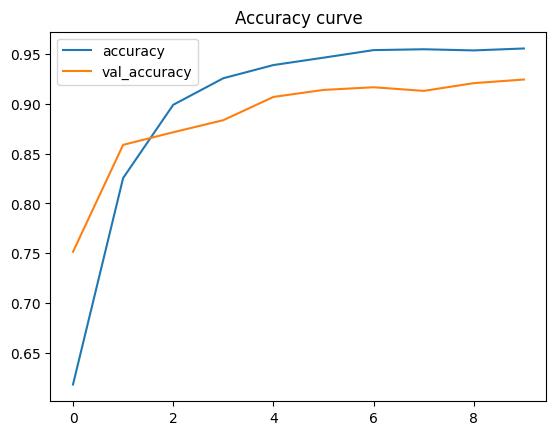

In [24]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['accuracy', 'val_accuracy']].plot(title = 'Accuracy curve')

In [25]:
сап

NameError: name 'сап' is not defined

# Построение нейронной сети  в 5 слоев

In [ ]:
model=Sequential()
model.add(Conv2D(32,(3,3),input_shape=(120,120,3),activation="relu"))
model.add(MaxPooling2D(pool_size=(3,3)))
model.add(Flatten())
model.add(Dense(256,activation="relu"))
model.add(Dense(4,activation="softmax"))


In [ ]:
model.compile(loss=keras.losses.categorical_crossentropy,
             optimizer=keras.optimizers.Adam(),
             metrics=["accuracy"])

In [ ]:
history = model.fit(X_train,y_train,epochs=10,validation_data=(X_test,y_test),batch_size=128,
                    verbose=1)

In [ ]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot(title = 'Loss curve')

In [ ]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['accuracy', 'val_accuracy']].plot(title = 'Accuracy curve')

In [ ]:
варпвапвап

# Построение нейронной сети в 13 слоев и обучение

In [ ]:
model=Sequential()
model.add(Conv2D(32,(3,3),input_shape=(120,120,3),activation="relu"))
model.add(MaxPooling2D(pool_size=(3,3)))
model.add(Conv2D(64,(3,3),activation="relu"))
model.add(MaxPooling2D(pool_size=(3,3)))
model.add(Conv2D(64,(3,3),activation="relu"))
model.add(MaxPooling2D(pool_size=(4,4)))
model.add(Flatten())
model.add(Dense(128,activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(128,activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(256,activation="relu"))
model.add(Dense(4,activation="softmax"))

In [ ]:
# early_stopping = tf.keras.callbacks.EarlyStopping(patience=5,min_delta=0.001,restore_best_weights=True)

Сборка и обучение модели

In [ ]:
model.compile(loss=keras.losses.categorical_crossentropy,
             optimizer=keras.optimizers.Adam(),
             metrics=["accuracy"])

In [ ]:
history = model.fit(X_train,y_train,epochs=10,validation_data=(X_test,y_test),batch_size=128,
                    verbose=1)

# Анализ результатов обучения

In [ ]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot(title = 'Loss curve')

In [ ]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['accuracy', 'val_accuracy']].plot(title = 'Accuracy curve')

In [ ]:
result = model.evaluate(X_test, y_test)

loss = result[0]
accuracy = result[1]
print(f"[+] Accuracy: {accuracy*100:.2f}%")

In [ ]:
from keras.models import Model
model.save('my_model_steel.keras')

In [ ]:
from keras.models import load_model

loaded_model = load_model('my_model.h5')


# Архитектура созданной нейронной сети

In [ ]:
model.summary()

# Тестирование на новых примерах

In [ ]:
l2[:3]

In [ ]:
X= np.array(l1[:3])
X = X/255

y = encoder.fit_transform(l2[:3])
y = np.array(y)

In [ ]:
plt.imshow(l1[0]);

In [ ]:
plt.imshow(l1[1]);

In [ ]:
plt.imshow(l1[2]);

In [ ]:
y =  to_categorical(y)
y

In [ ]:

predictions = model.predict(X)
predictions

Здесь три эксперимента, где мы видим, что тест № 2 был с меткой 3, но неверно идентифицировался как метка 1.

In [ ]:
model.summary()

# описание архитектуры нейронной сети

У нас тут многослойная нейронная сеть с разными типами слоев.

теперь по поводу слоев нейронной сети и их особенностей.

1 слой - Conv2D. Он используется для выполнения двумерной свертки входных данных. Он применяет набор фильтров к входному изображению или карте объектов, перемещая их по входным данным и вычисляя скалярное произведение в каждом месте. Эта операция позволяет слою извлекать объекты и фиксировать пространственные отношения во входных данных. Уровень Conv2D обычно используется в сверточных нейронных сетях (CNN) для таких задач, как классификация изображений, обнаружение объектов и сегментация изображений.

2 слой - MaxPooling2D.  Это  операция понижающей дискретизации, которая уменьшает пространственные размеры (ширину и высоту) входного изображения или карты объектов. Он делит входные данные на непересекающиеся прямоугольники и выводит максимальное значение внутри каждого прямоугольника. Это помогает извлечь наиболее важные функции и снизить вычислительные требования для последующих слоев.

Далее эти слои повторяются еще 2 раза.

7 слой - Flatten. он преобразует входной тензор в одномерный массив, эффективно выравнивая его. Он принимает многомерный входной тензор, например двумерное изображение, и преобразует его в одномерный вектор, который можно использовать в качестве входных данных для полностью связного слоя или любого другого слоя, который ожидает одномерных входных данных.

8 слой - Dense. это полностью связный слой, который соединяет каждый нейрон предыдущего слоя с каждым нейроном текущего слоя. Он выполняет линейную операцию над входными данными, за которой следует функция активации, позволяющая сети изучать сложные закономерности и взаимосвязи в данных. Количество нейронов в плотном слое определяет размерность вывода.

9 cлой - Dropout. это метод регуляризации, используемый для уменьшения переобучения в нейронных сетях. Он случайным образом устанавливает для части входных единиц значение 0 на каждом этапе обучения, что помогает предотвратить слишком большую зависимость сети от конкретных функций или корреляций. Dropout улучшает способность модели к обобщению за счет внесения шума во время обучения и побуждает сеть изучать более надежные и независимые представления.

Далее слои повторяются.

В итоге в данной нейронной сети 12 различных слоев, и 139 780 параметров.